In [1]:
import pandas as pd

data = pd.read_csv("final_merged_5min.csv", index_col=0)

In [2]:
data.isna().sum()

TCAS_std         0
TCAS_mean        0
TCAS_close       0
TCAS_delta       0
TCAS_corr        0
TCBS_std         0
TCBS_mean        0
TCBS_close       0
TCBS_delta       0
TCBS_corr        0
ALPHA_std        0
ALPHA_mean       0
ALPHA_close      0
ALPHA_delta      0
ALPHA_corr       0
BETA_std         0
BETA_mean        0
BETA_close       0
BETA_delta       0
BETA_corr        0
ZETA_std         0
ZETA_mean        0
ZETA_close       0
ZETA_delta       0
ZETA_corr        0
WMP_std          0
WMP_delta        0
WMP_corr         0
AWS_std          0
AWS_mean         0
AWS_close        0
AWS_delta        0
AWS_corr         0
VOL_std          0
VOL_mean         0
VOL_close        0
VOL_delta        0
VOL_corr         0
GAP_std          0
GAP_mean         0
GAP_close        0
GAP_delta        0
GAP_corr         0
nUoD_std         0
nUoD_mean        0
nUoD_close       0
nUoD_delta       0
nUoD_corr        0
PSTD_std         0
PSTD_mean        0
PSTD_close       0
PSTD_delta       0
PSTD_corr   

In [3]:
data = data.drop(columns=data.columns[data.isna().sum() > 10_000])

In [4]:
print("Size before dropna", len(data))
data.dropna(how="any", inplace=True)
print("Size after dropna", len(data))

Size before dropna 5250
Size after dropna 5125


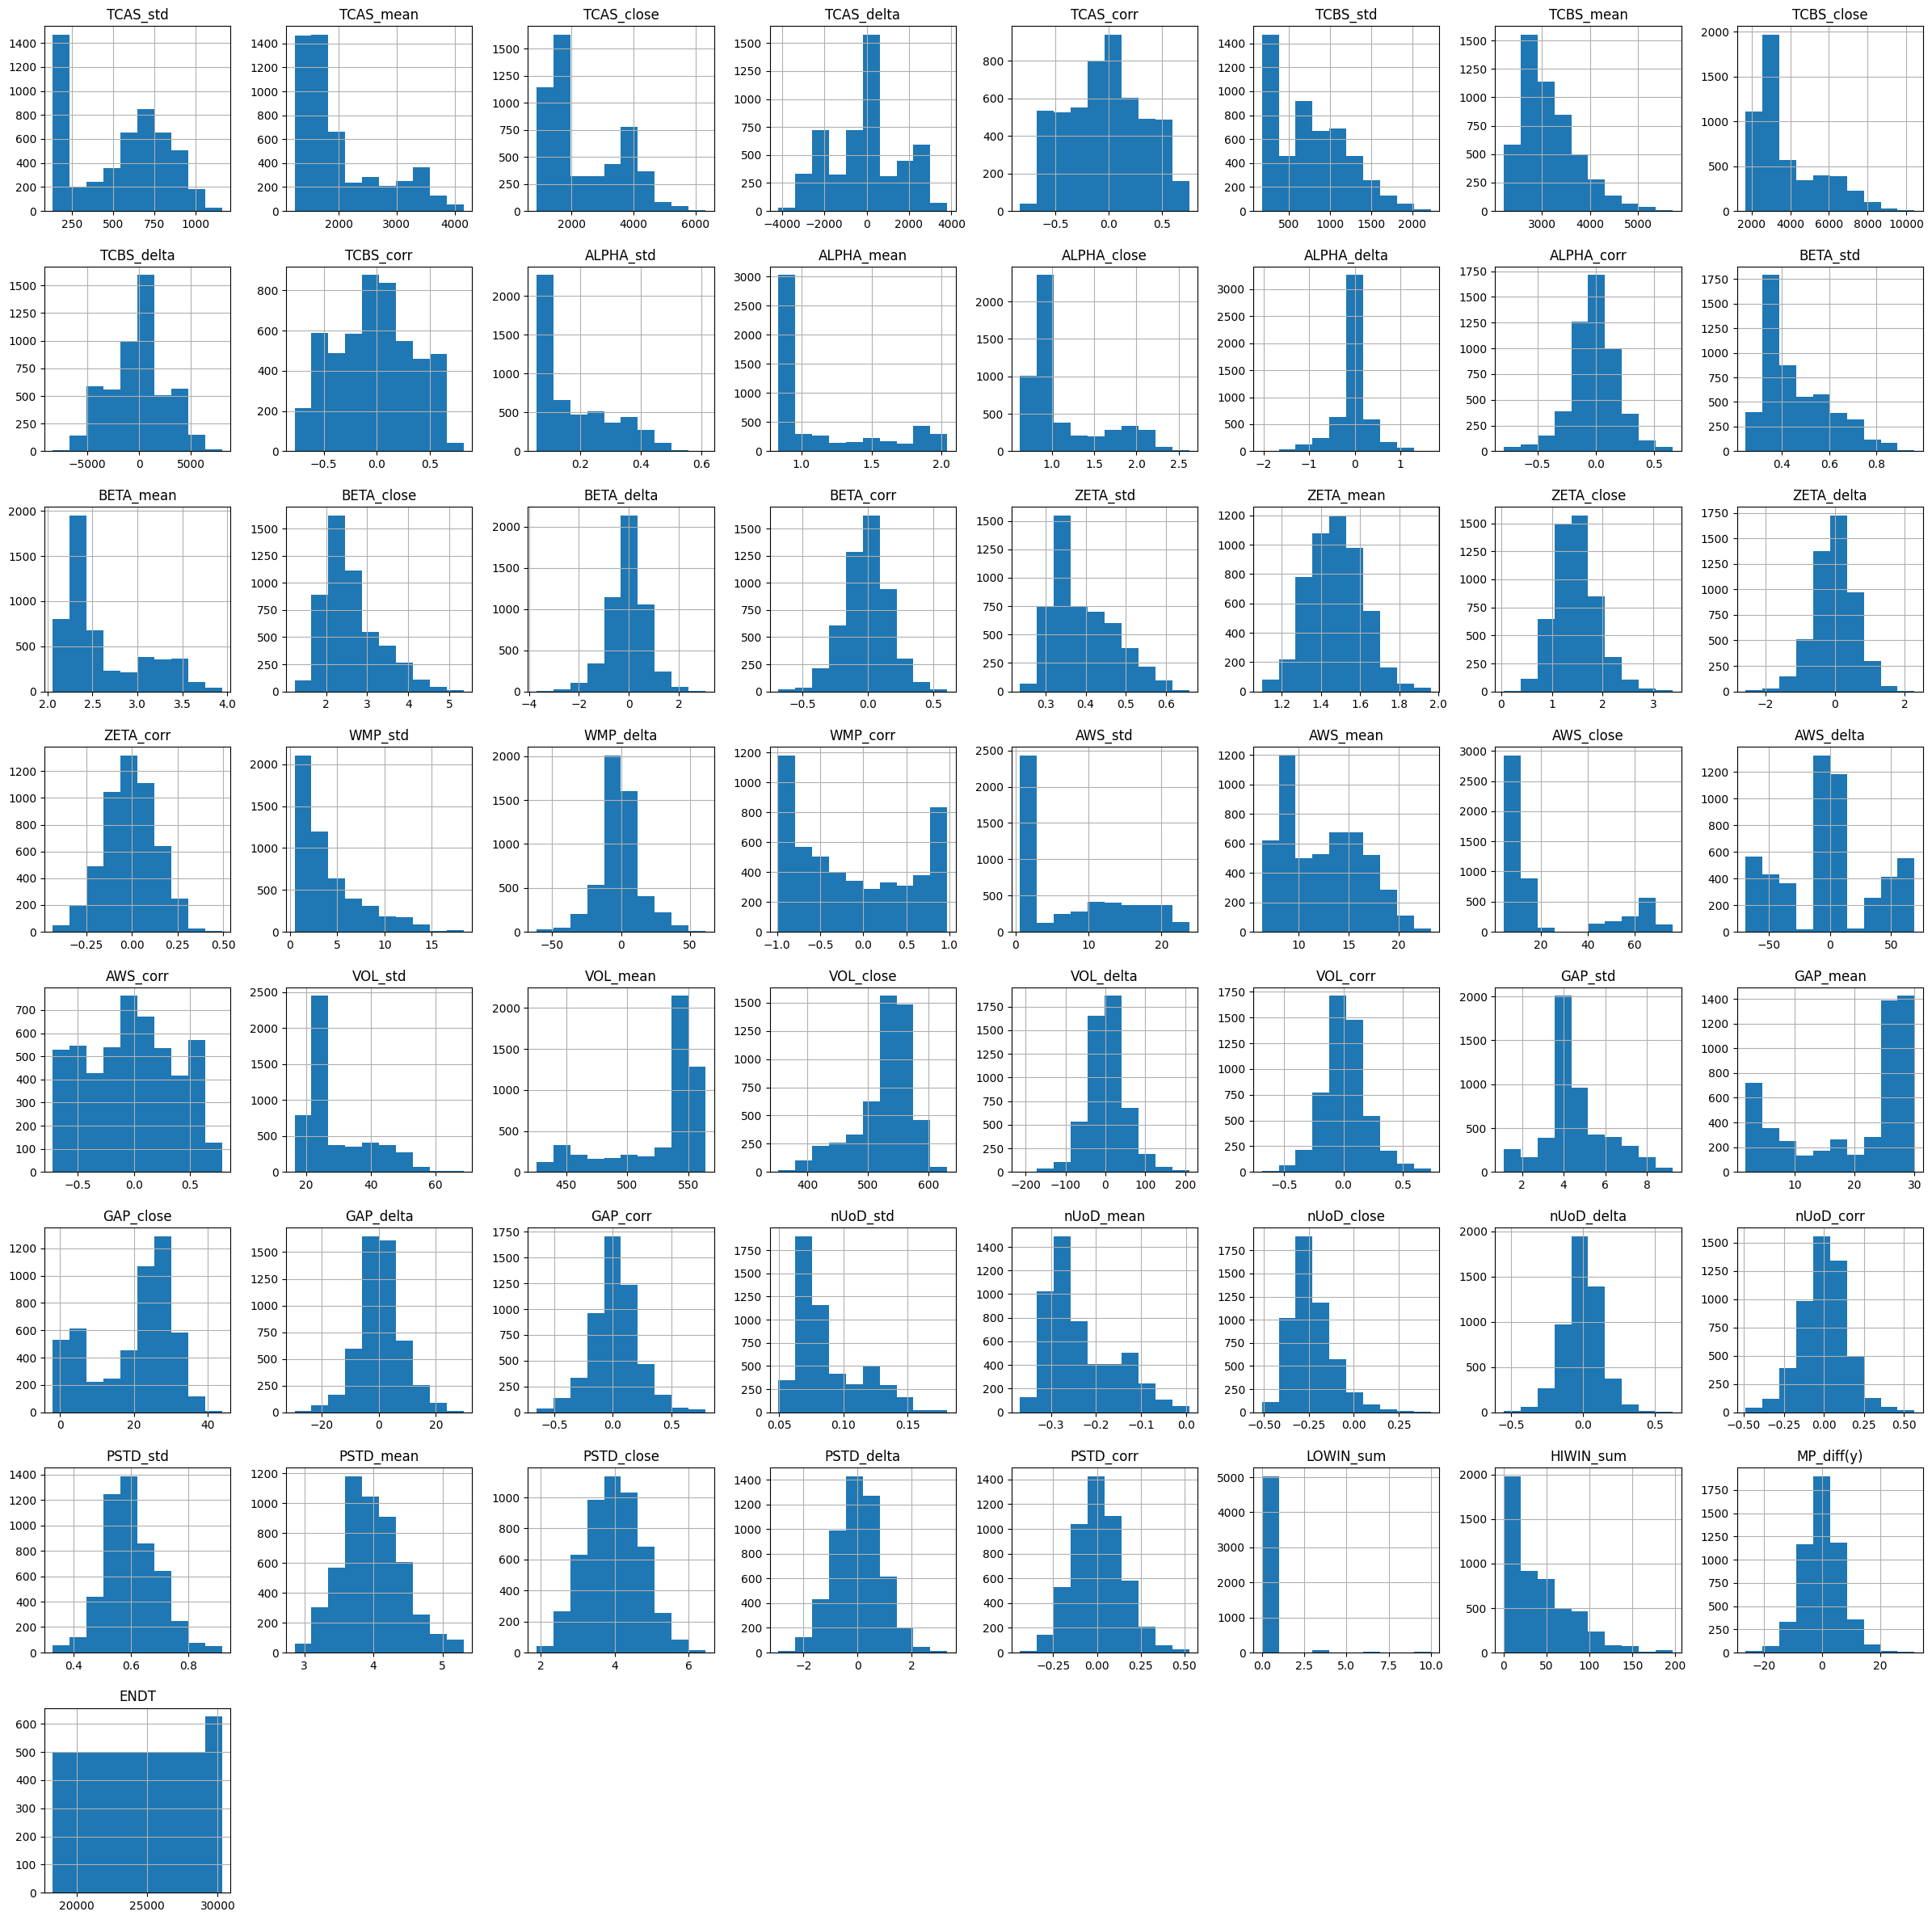

In [5]:
import matplotlib.pyplot as plt
data.hist(figsize=(30,30))
plt.show()

In [6]:
x_features = list(data)
x_features.remove("MP_diff(y)")
x_features.remove("ENDT")

# scale data between 0 and 1
for col in x_features:
    #data[col] = np.log(data[col] + data[col].min())
    data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

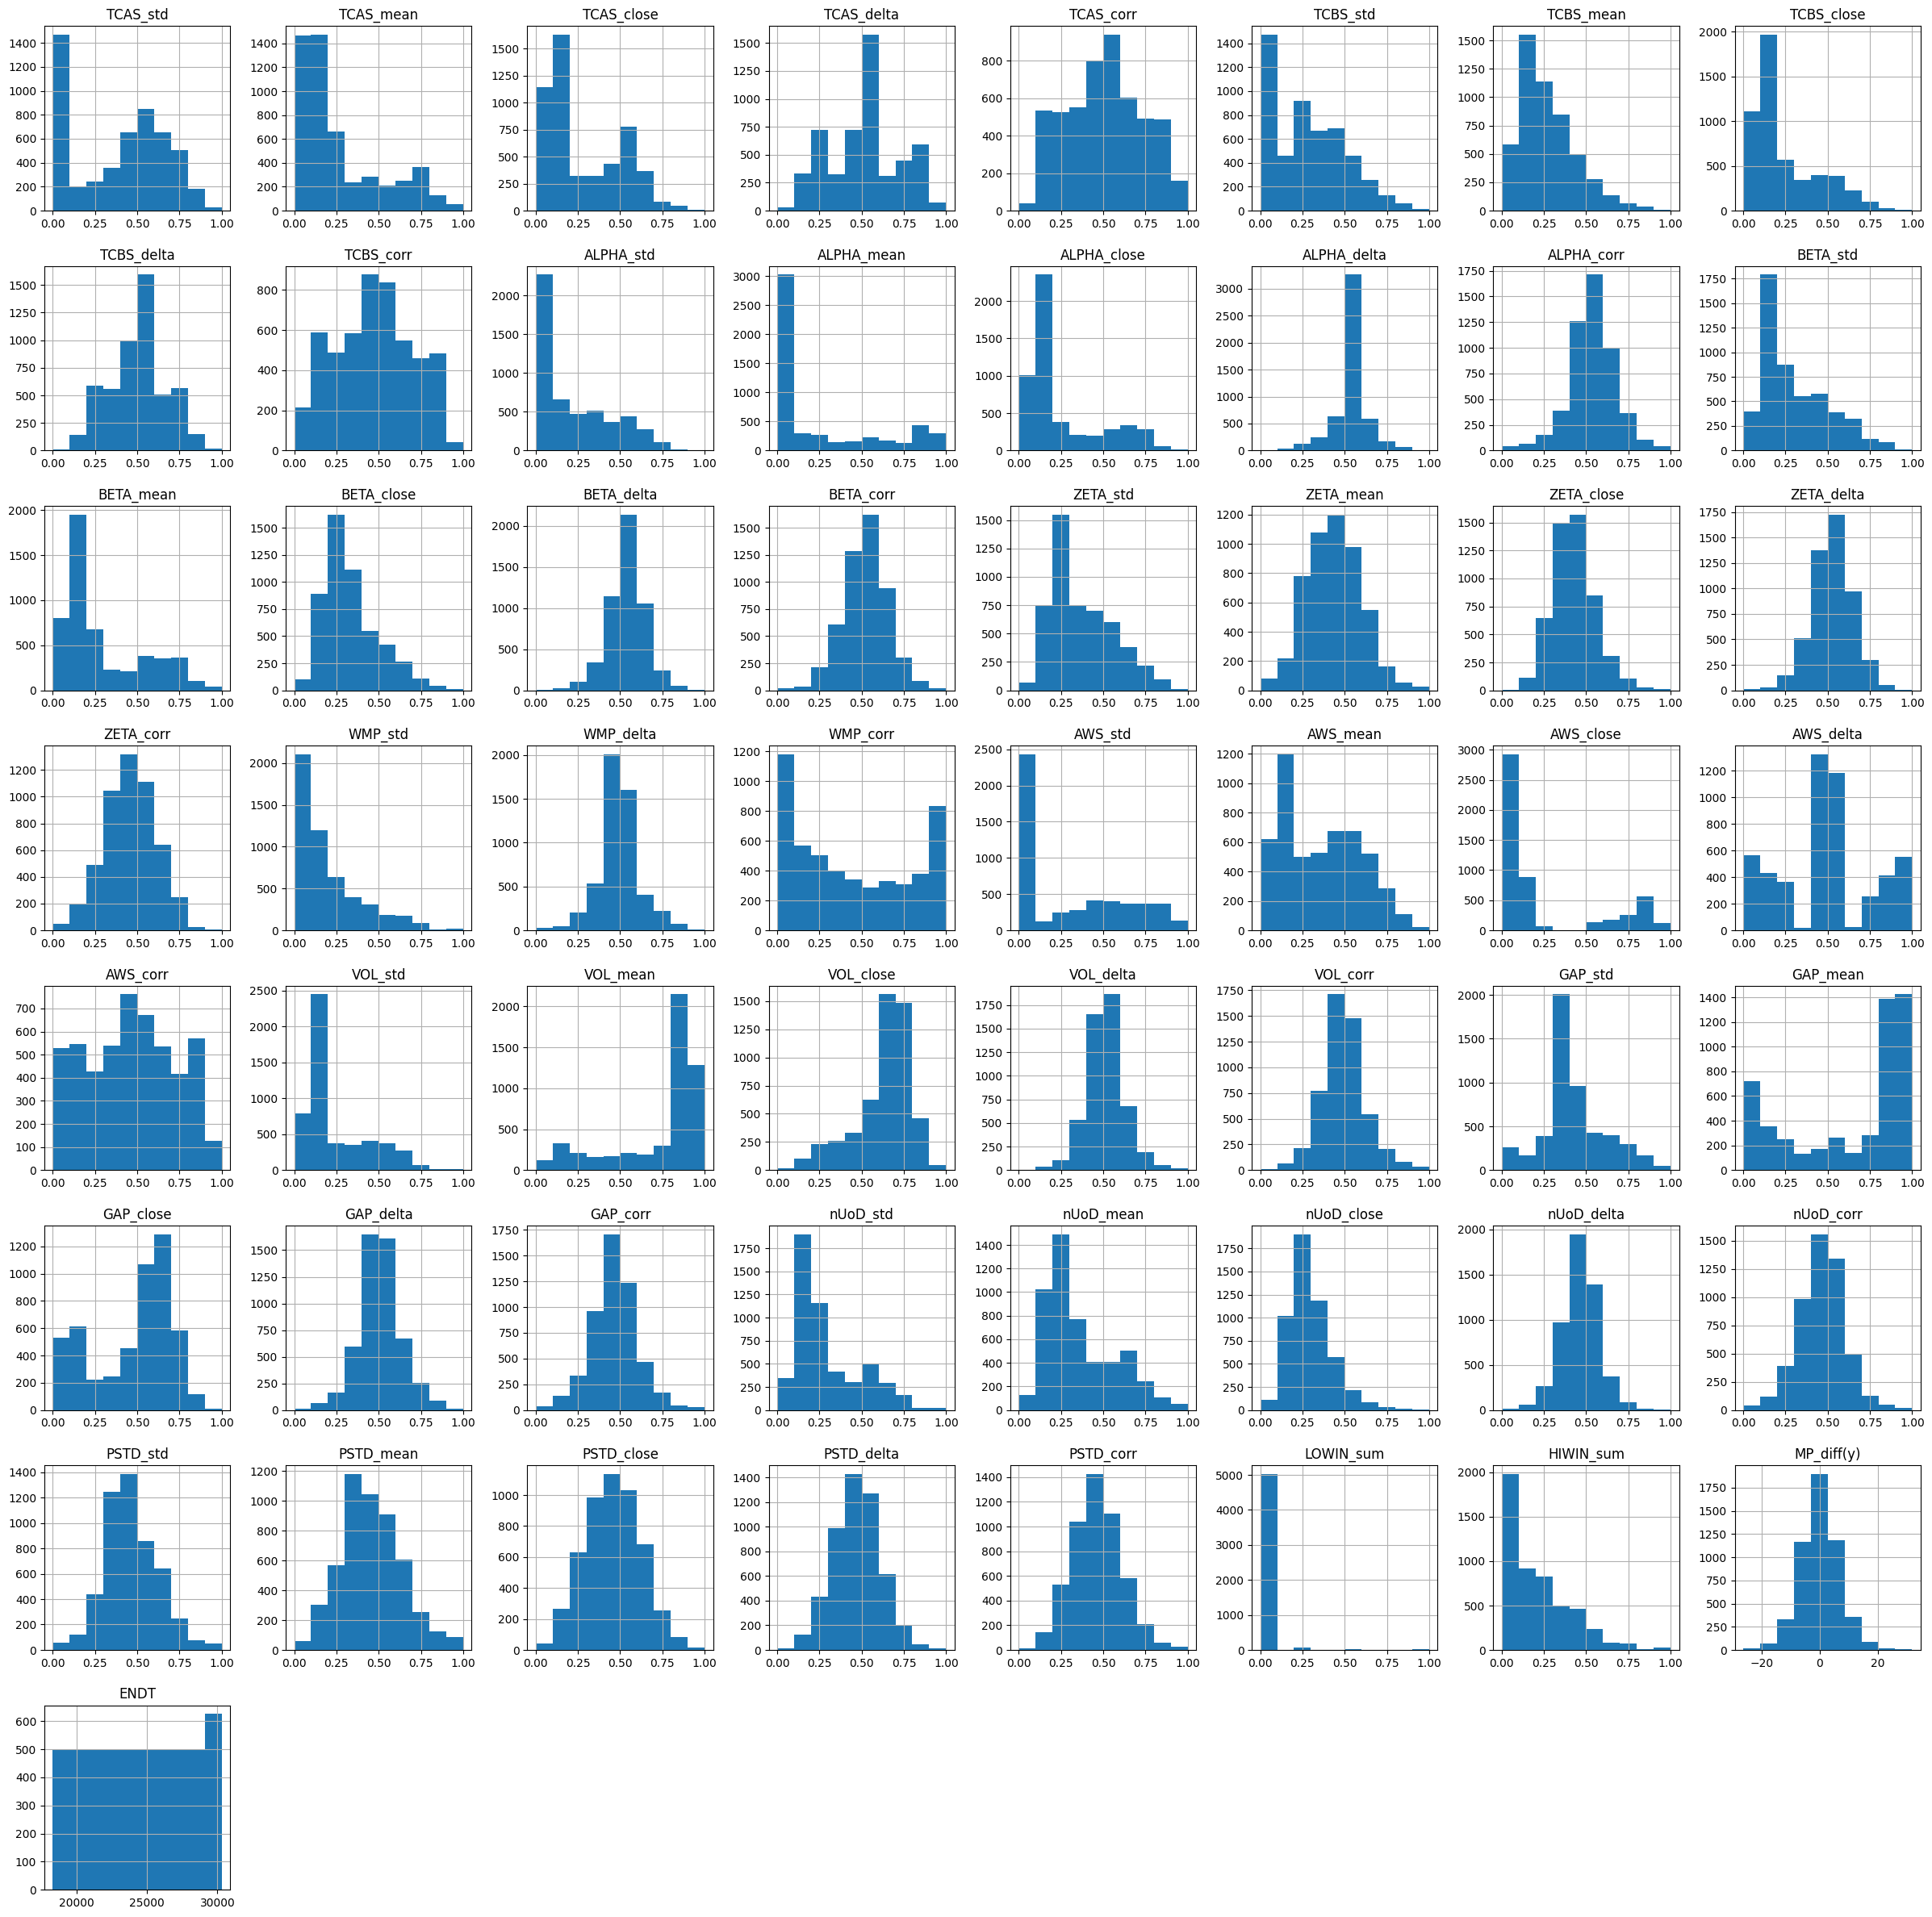

In [7]:
data.hist(figsize=(30,30))
plt.show()

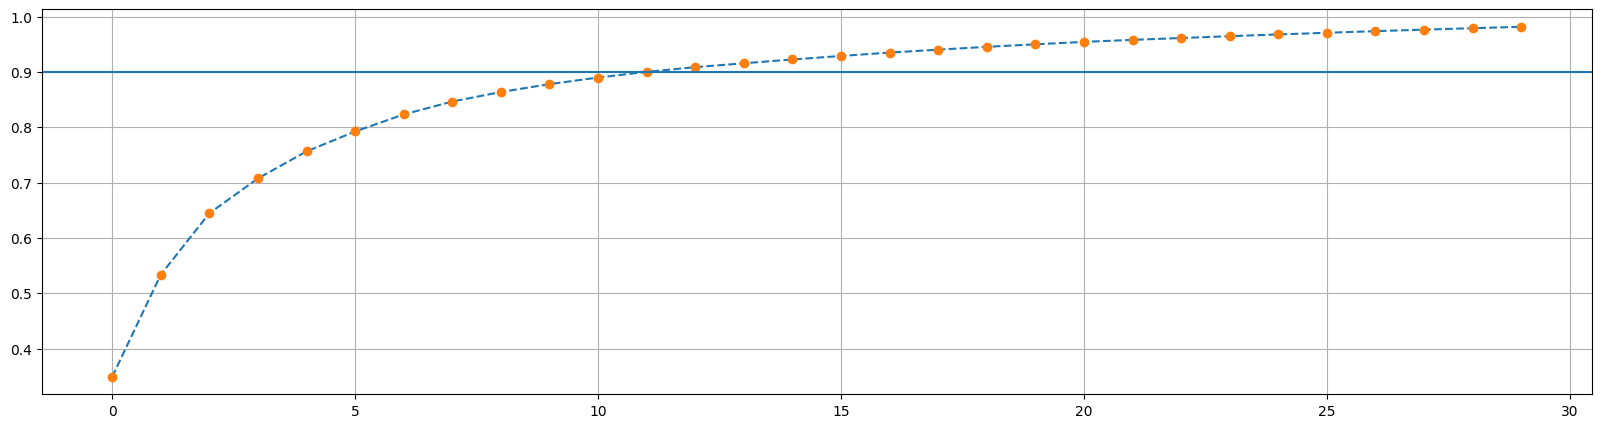

In [8]:
# apply pca
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=30)
pca_vectors = pca.fit_transform(data[x_features])

plt.figure(figsize=(20,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linestyle = "--")
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o')
plt.axhline(0.9)
plt.grid()

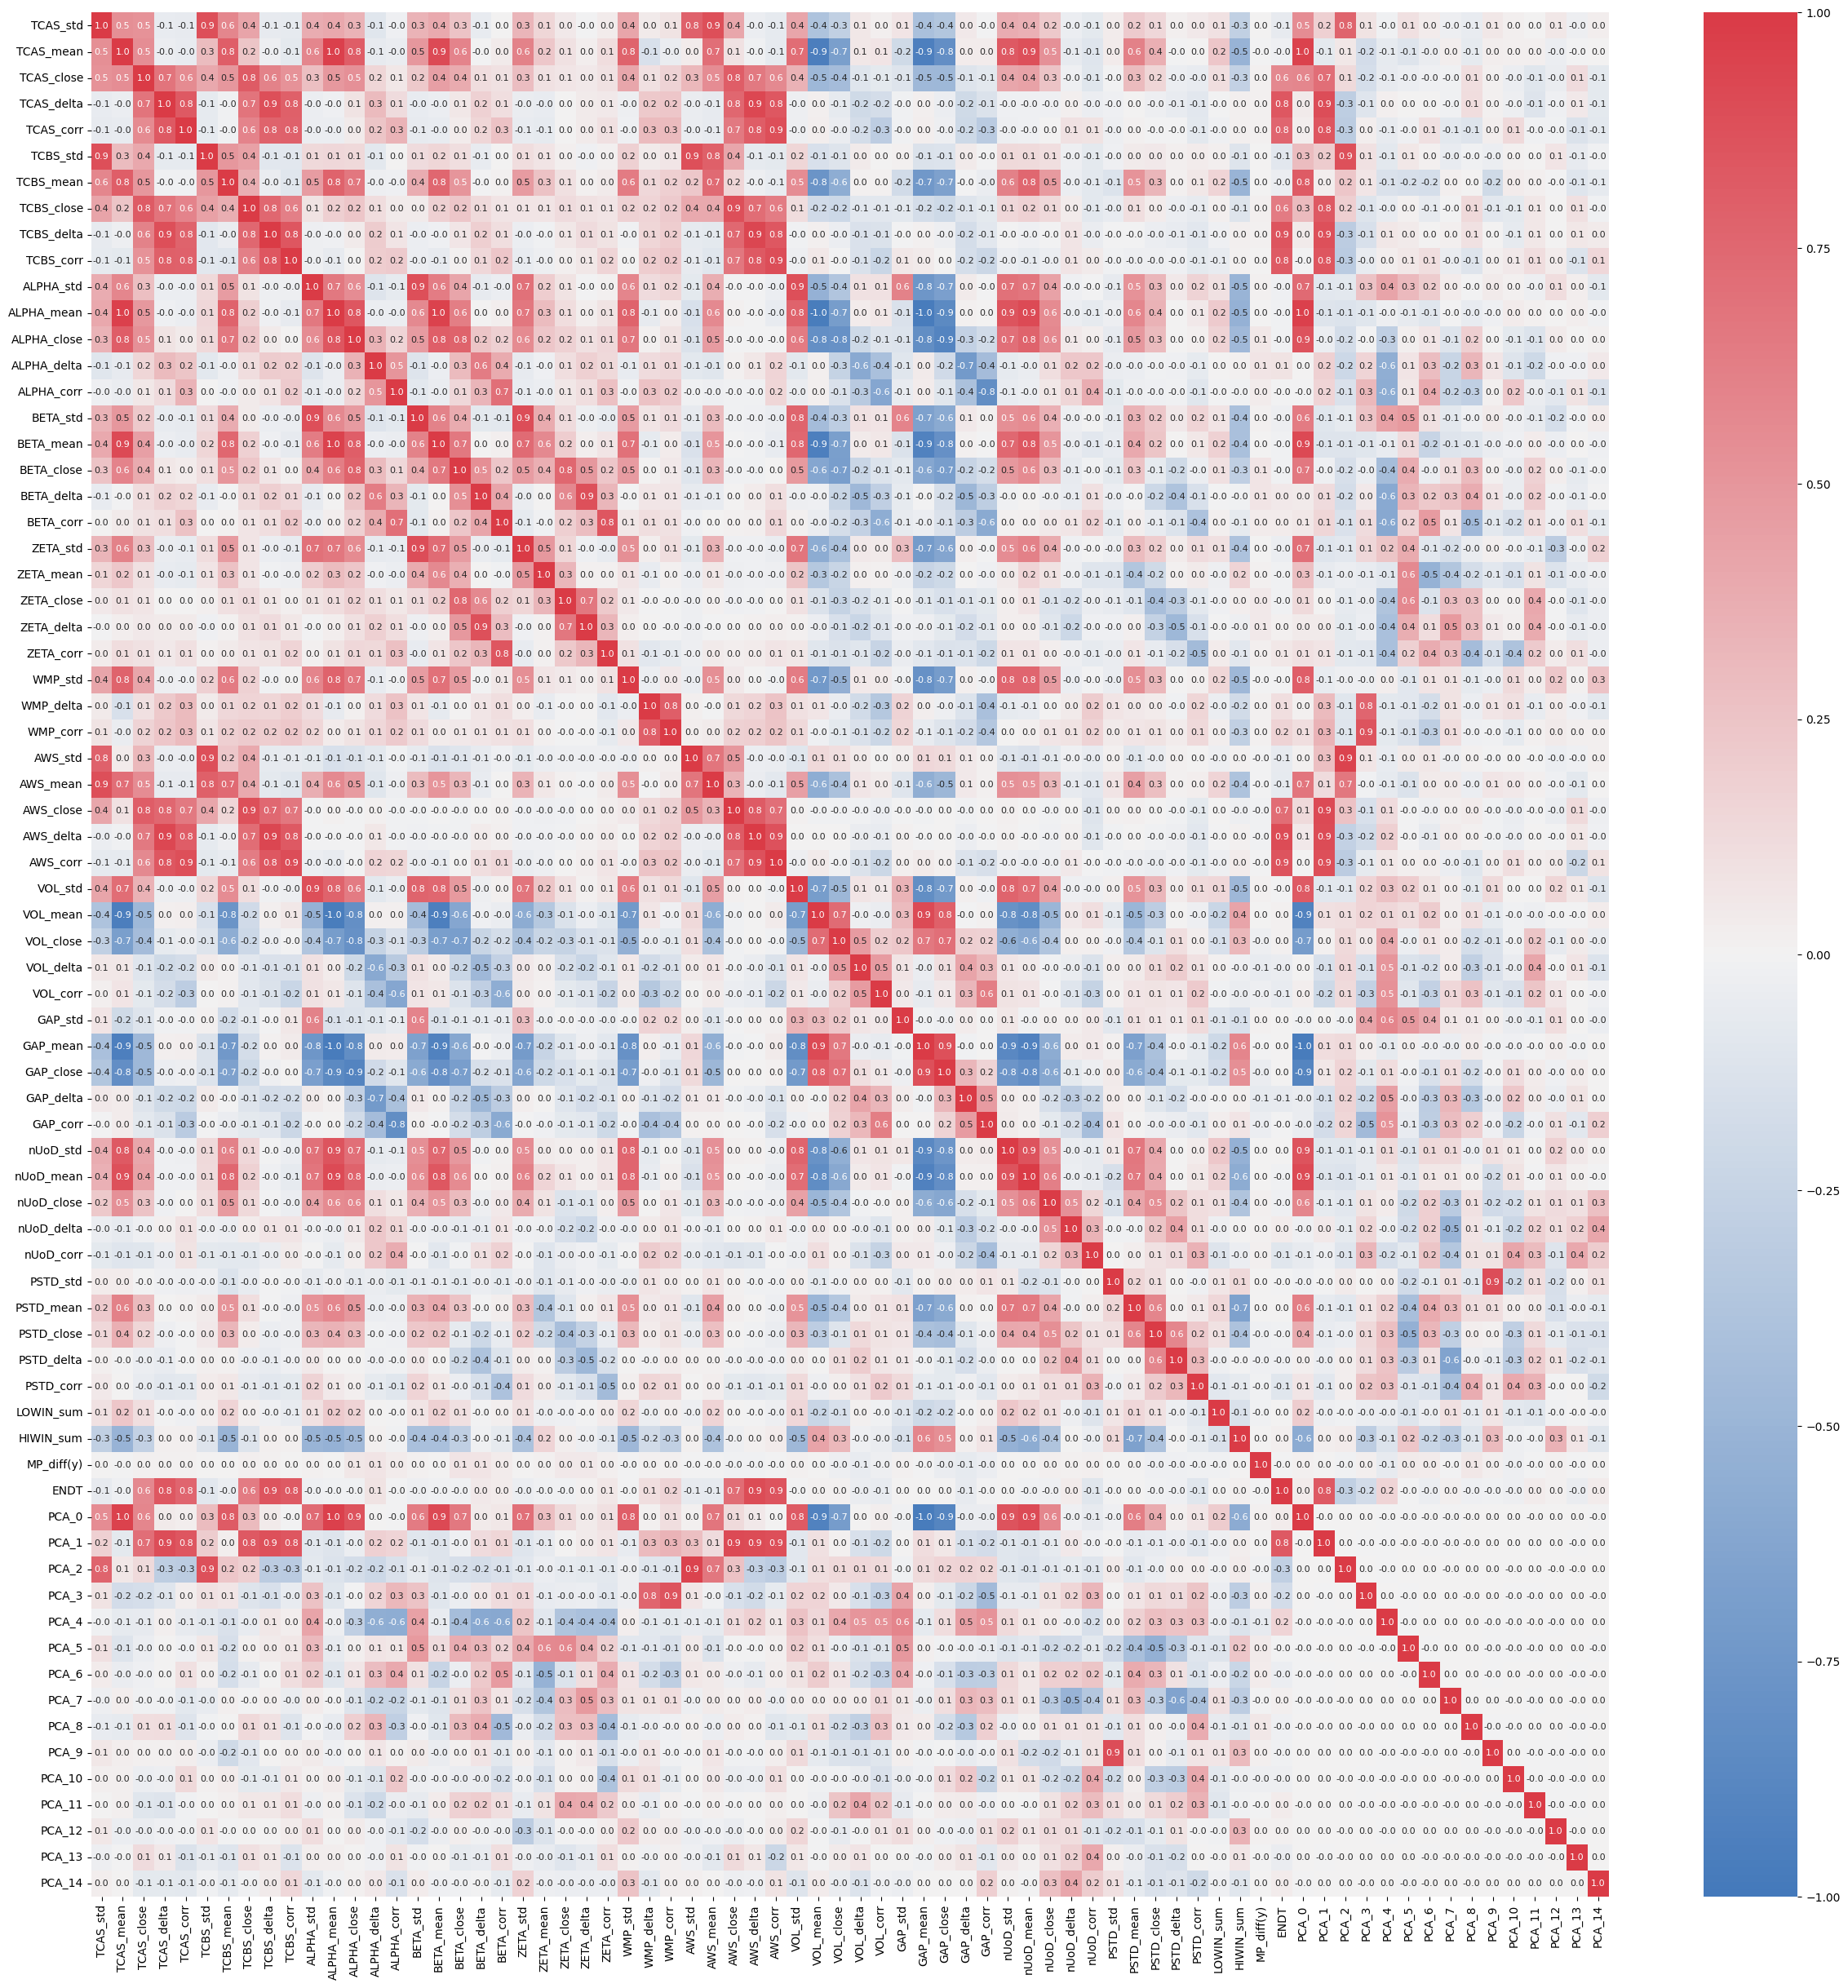

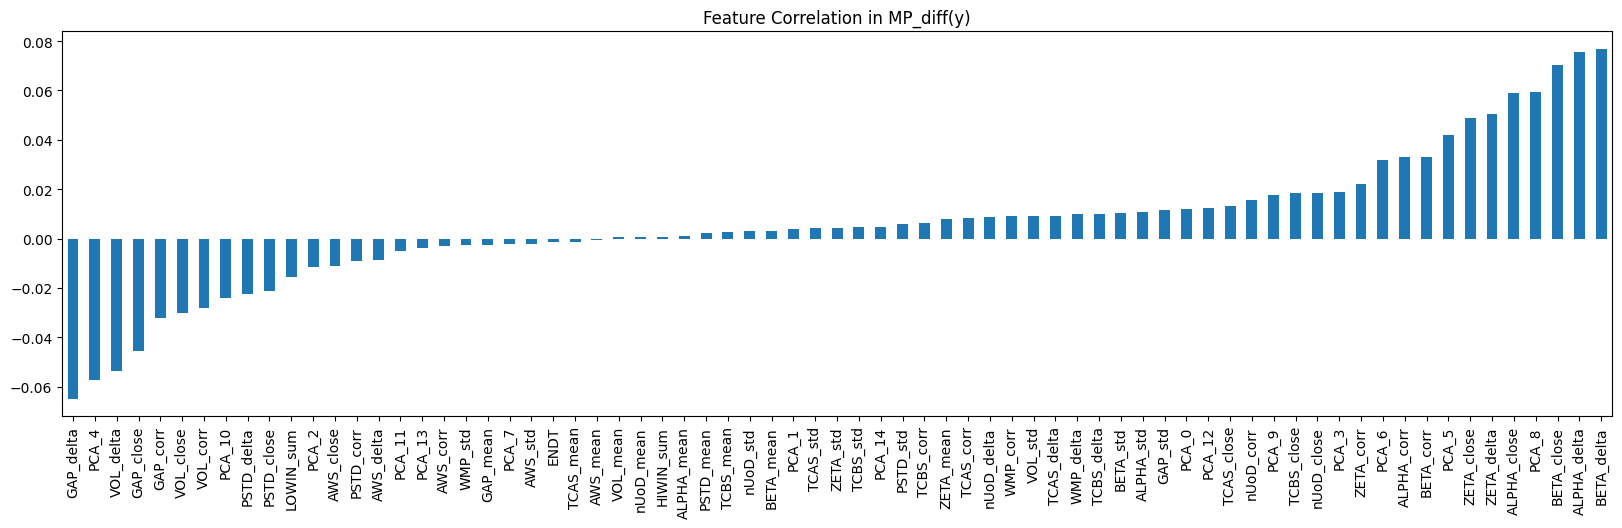

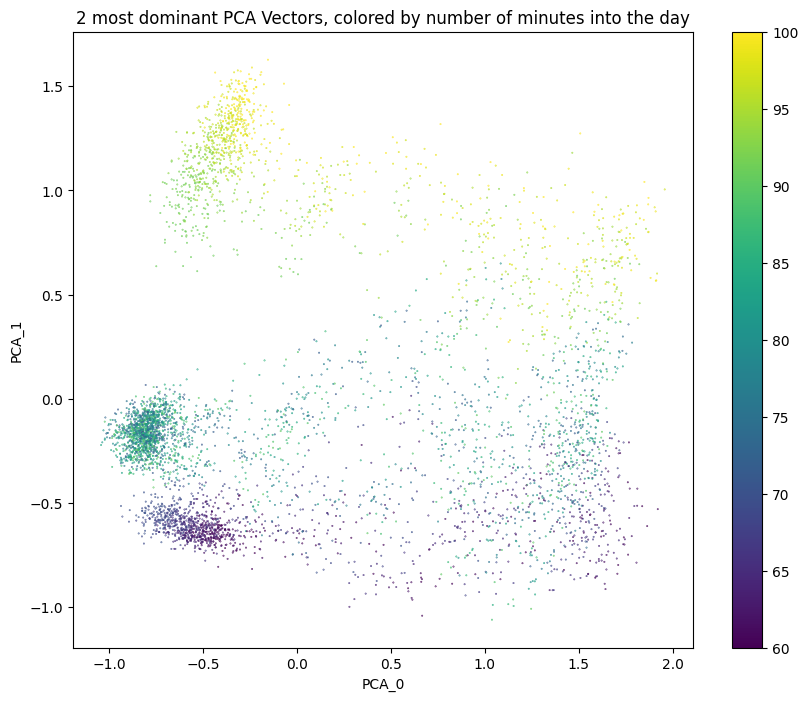

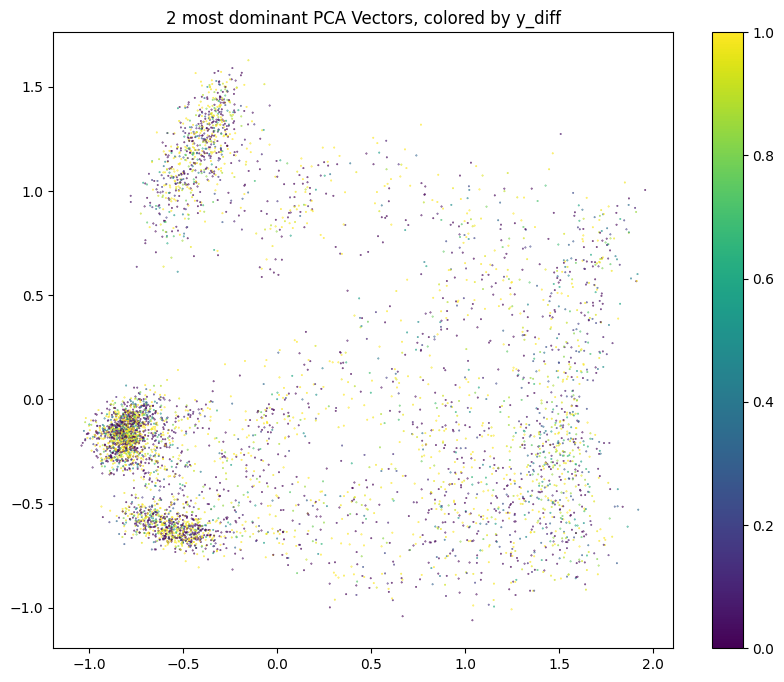

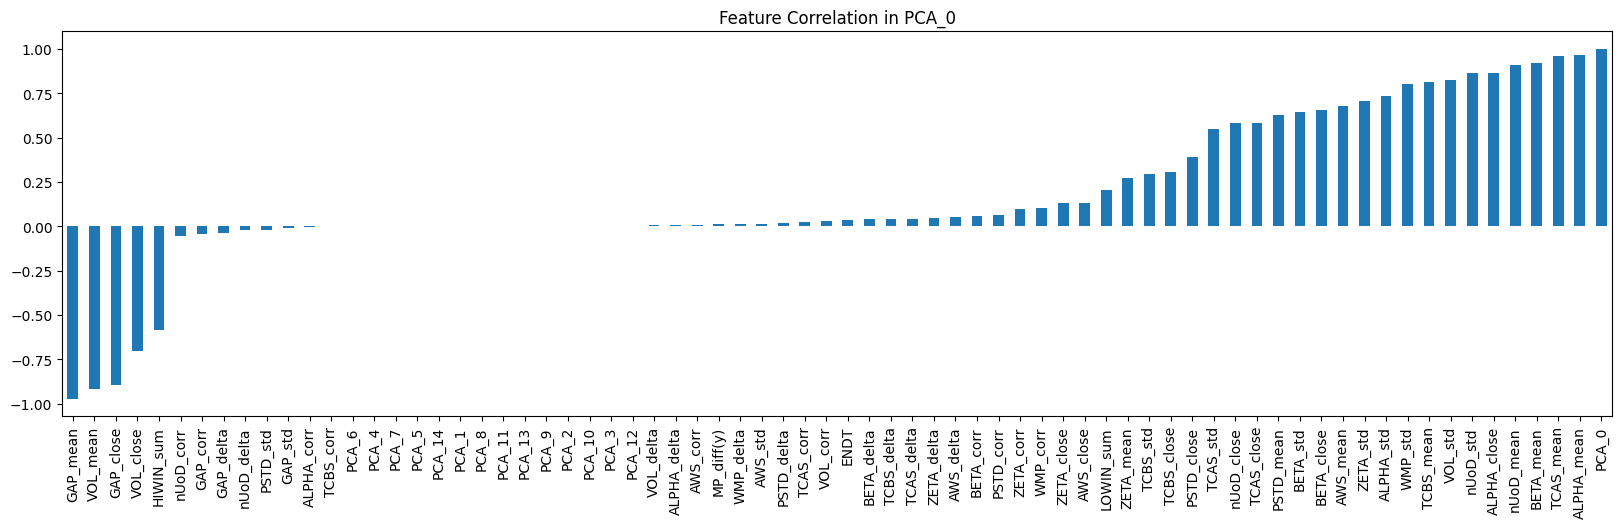

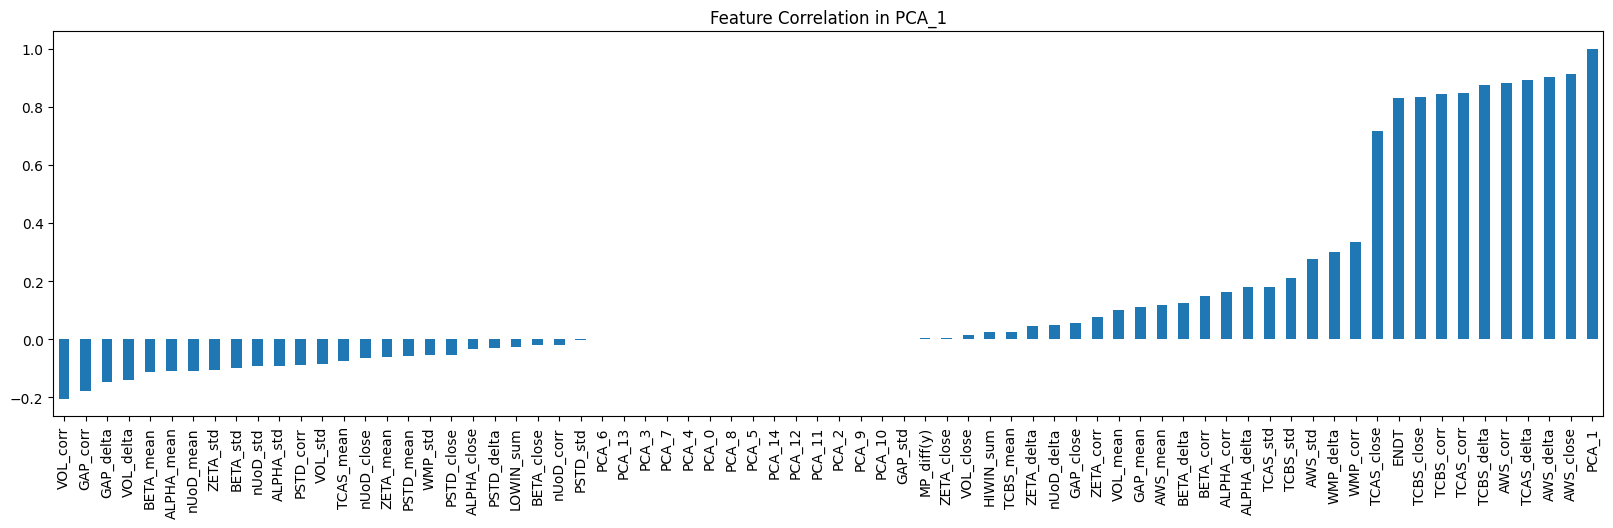

In [9]:
X = pca_vectors[:,:15]
y_diff = data["MP_diff(y)"]
import seaborn as sns


for i in range(X.shape[1]):
    data[f"PCA_{i}"] = X[:,i]

plt.figure(figsize=(30,30))
corr_map = data.corr()
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr_map, vmin=-1, vmax=1, cmap=cmap, center=0, annot=True, fmt=".1f", annot_kws={"size": 8})
plt.show()

corr_map[corr_map.index != "MP_diff(y)"]["MP_diff(y)"].sort_values().plot(kind = "bar", figsize=(20,5))
plt.title("Feature Correlation in MP_diff(y)")
plt.show()

plt.figure(figsize=(10,8))
plt.title("2 most dominant PCA Vectors, colored by number of minutes into the day")
plt.scatter(X[:,0], X[:,1], c = data.index.to_numpy(), s = 1/2**3)
plt.xlabel("PCA_0")
plt.ylabel("PCA_1")
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.title("2 most dominant PCA Vectors, colored by y_diff")
plt.scatter(X[:,0], X[:,1], c = 1/ (1 + np.exp(-y_diff.to_numpy())), s = 1/2**3)
plt.colorbar()
plt.show()

corr_map["PCA_0"].sort_values().plot(kind = "bar", figsize=(20,5))
plt.title("Feature Correlation in PCA_0")
plt.show()
corr_map["PCA_1"].sort_values().plot(kind = "bar", figsize=(20,5))
plt.title("Feature Correlation in PCA_1")
plt.show()

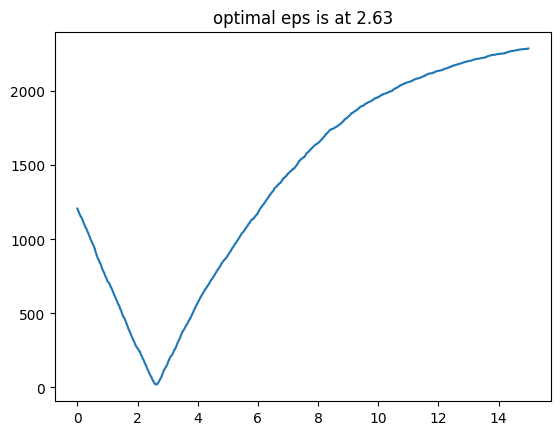

In [10]:
eps_vals = np.arange(0, 15, 0.01)

def eps_y_bool(arr, eps):
    return np.std([np.sum(arr > eps),np.sum(arr < -eps), np.sum( (arr < eps) & (arr > -eps) )])
    
split_ratios = []
for eps in eps_vals:
    split_ratios.append(eps_y_bool(y_diff, eps))

plt.title(f"optimal eps is at {eps_vals[np.argmin(split_ratios)]}")
plt.plot(eps_vals, split_ratios)
plt.show()

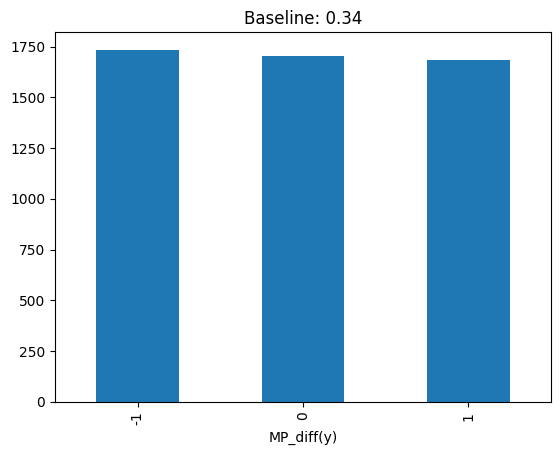

In [12]:
def gen_y_bool(y):
    if abs(y) < 2.63:
        return 0
    elif y > 0:
        return 1
    else:
        return -1
    
y_bool = y_diff.apply(gen_y_bool)
y_bool_splits = y_bool.value_counts()
y_bool_splits.plot(kind = "bar")
baseline = np.max(y_bool_splits) / len(data)
plt.title(f"Baseline: {baseline:.2f}")
plt.show()

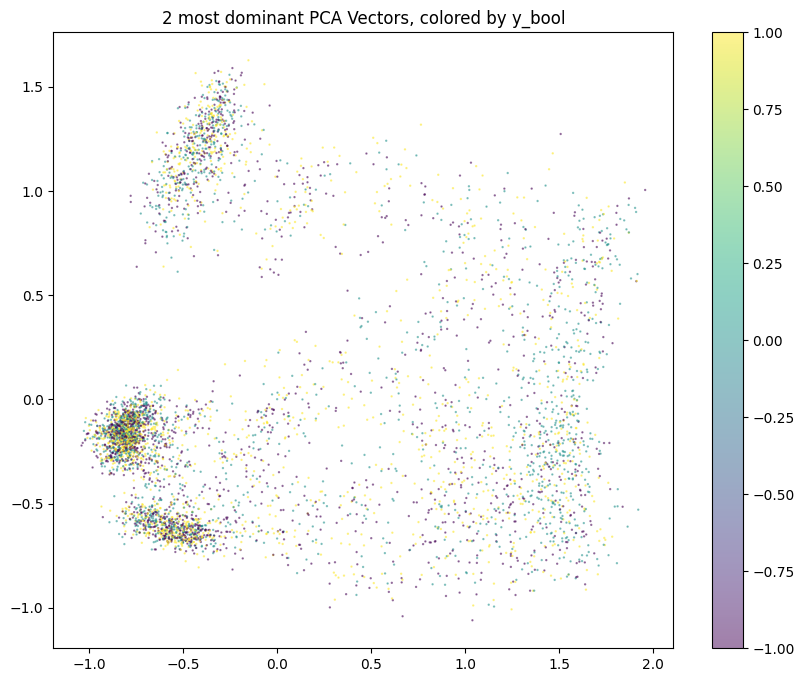

In [15]:
plt.figure(figsize=(10,8))
plt.title("2 most dominant PCA Vectors, colored by y_bool")
plt.scatter(X[:,0], X[:,1], c = y_bool.to_numpy(), s = 1/2**1, alpha=0.5)
plt.colorbar()
plt.show()

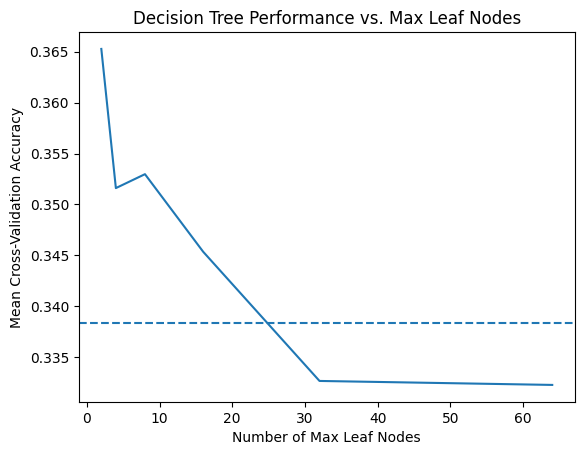

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


cv_scores = []
tree_nodes = [2,4,8,16,32,64]

mask = y_bool != 0

for n in tree_nodes:
    clf = DecisionTreeClassifier(max_leaf_nodes=n)
    scores = cross_val_score(clf, data[x_features], y_bool, cv=5)  # Assuming you have data X and labels y
    cv_scores.append(scores.mean())

plt.plot(tree_nodes, cv_scores)
plt.xlabel('Number of Max Leaf Nodes')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Decision Tree Performance vs. Max Leaf Nodes')
plt.axhline(baseline, linestyle = "--")
plt.show()

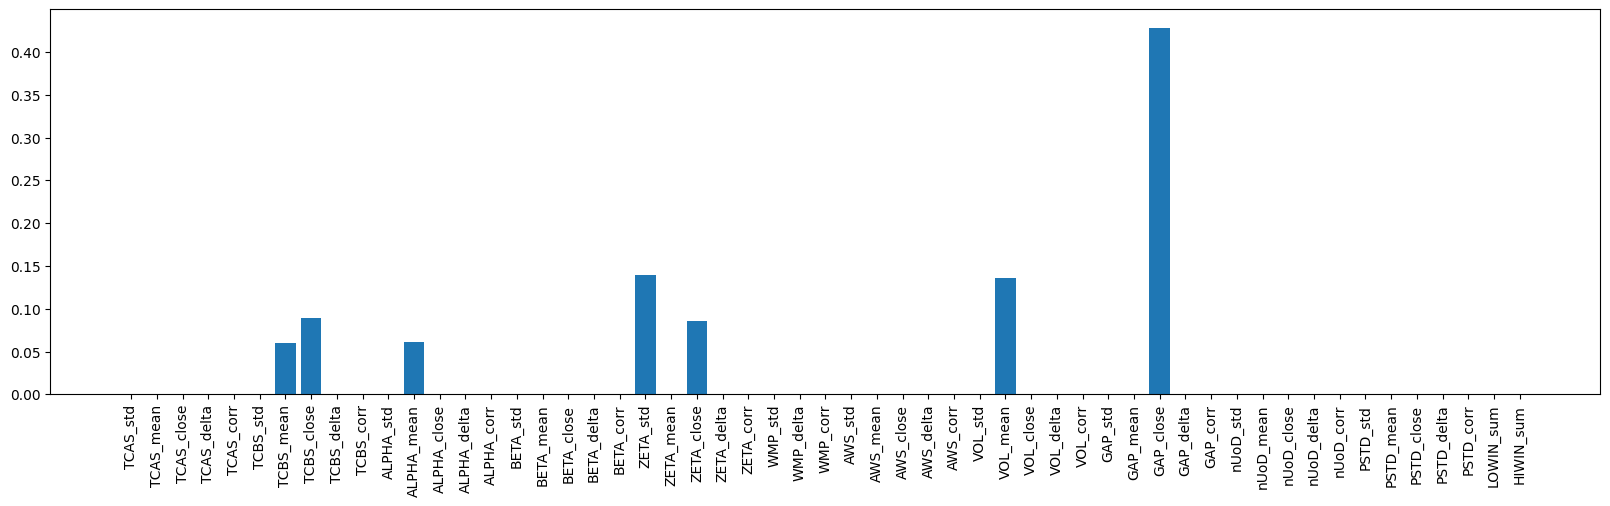

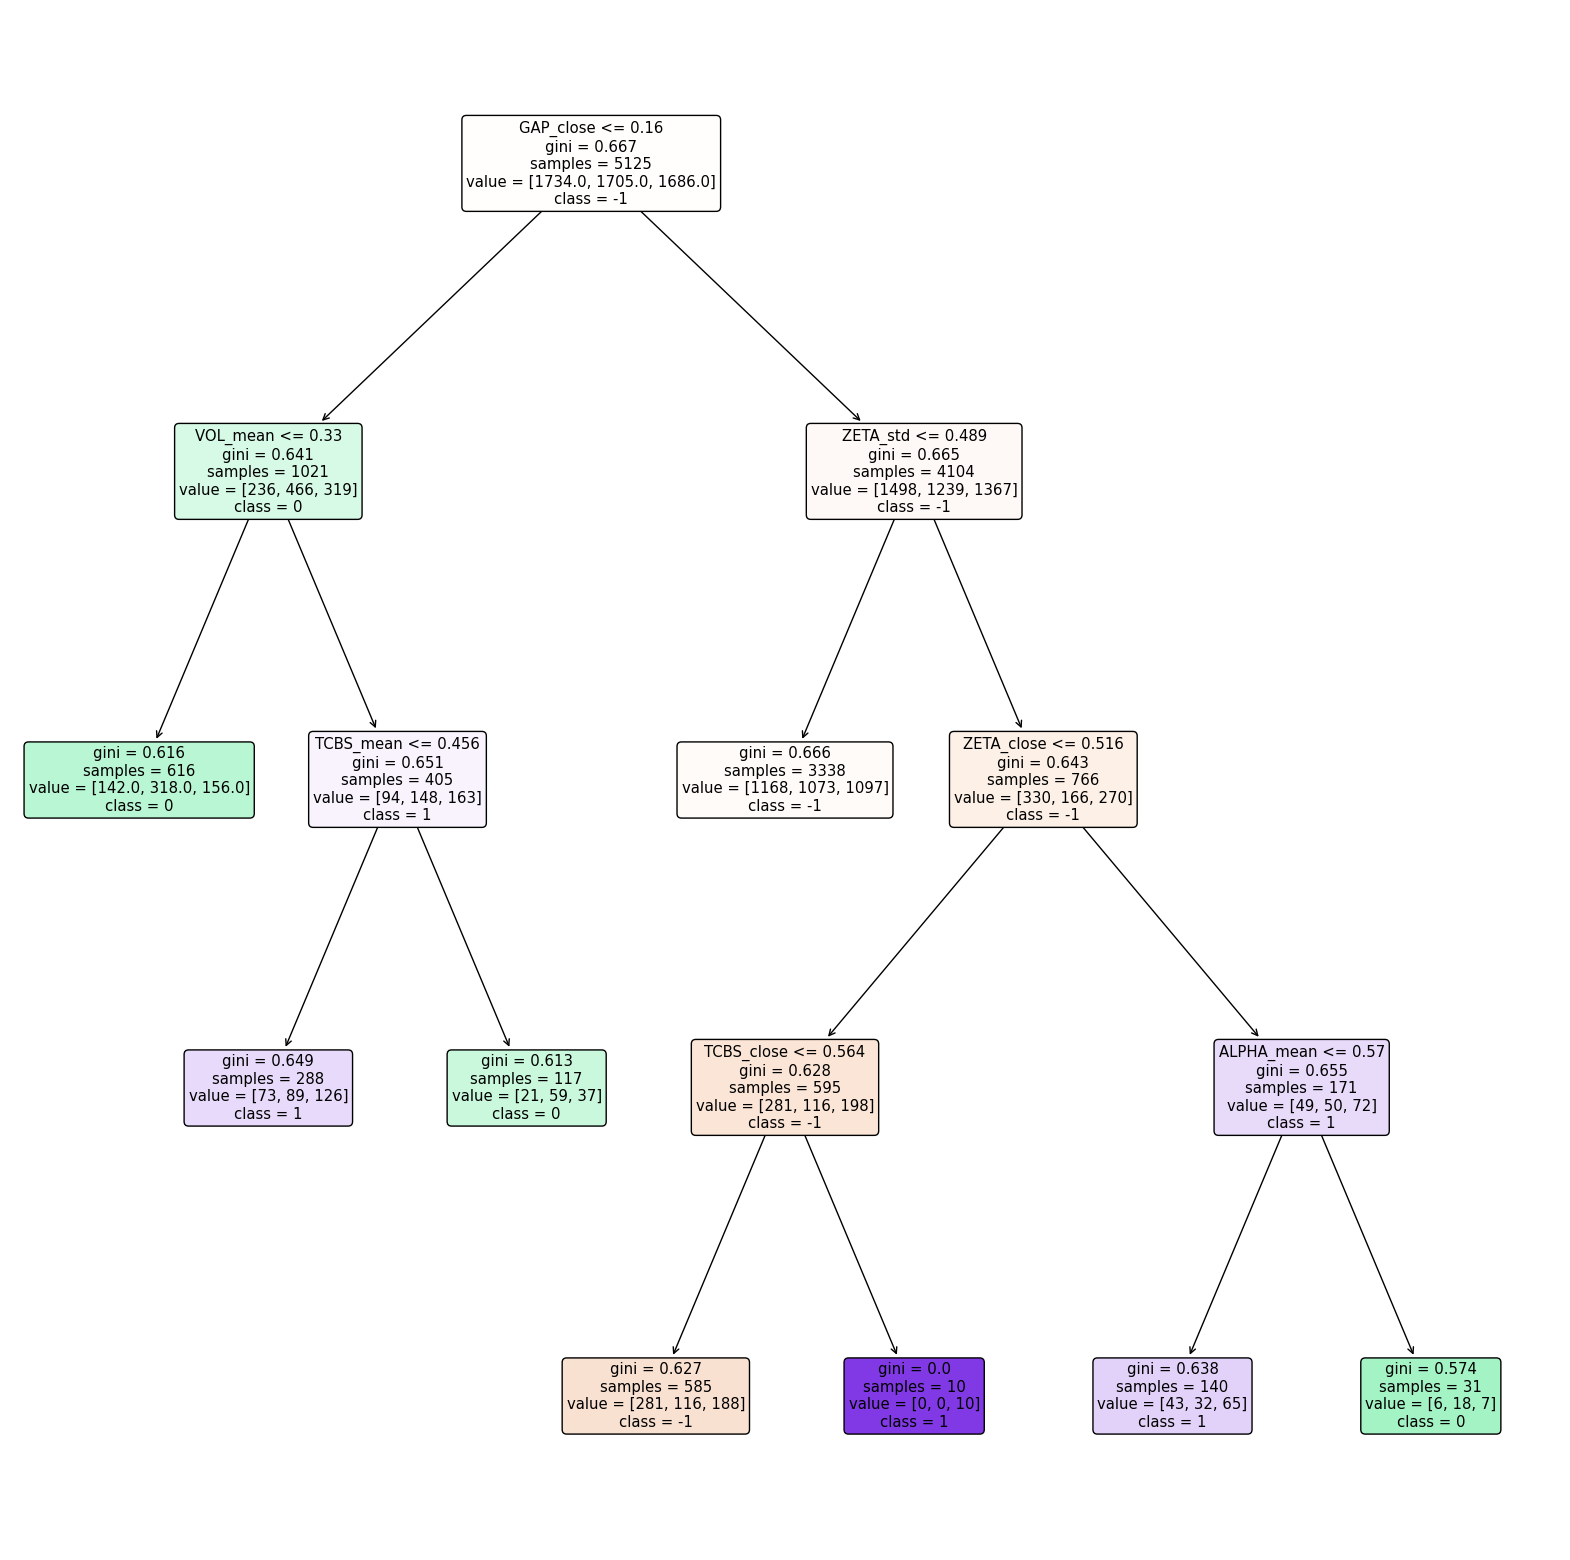

In [18]:
clf = DecisionTreeClassifier(max_leaf_nodes=8)
clf.fit(data[x_features],y_bool)

plt.figure(figsize=(20,5))
plt.bar(x_features, clf.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

from sklearn.tree import plot_tree

plt.figure(figsize=(20,20))
plot_tree(clf, feature_names=x_features, class_names=[str(a) for a in clf.classes_], filled=True, rounded=True)
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix

ypred = clf.predict(data[x_features])
ytrue = y_bool.to_numpy()
conf_matrix = confusion_matrix(ytrue, ypred, labels=clf.classes_)

for i, clas in enumerate(clf.classes_):
    print(f"Class {clas} Analysis...")
    
    print("Baseline =", np.mean(ytrue == clas))
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN
    
    print("TP =", TP)
    print("FP =", FP)
    print("TN =", TN)
    print("FN =", FN)
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print("Precision =", precision)
    print("Recall =", recall)
    print("F1 Score =", f1)
    print()


Class -1 Analysis...
Baseline = 0.33834146341463417
TP = 1449
FP = 2474
TN = 917
FN = 285
Precision = 0.3693601835330105
Recall = 0.8356401384083045
F1 Score = 0.5122856637793884

Class 0 Analysis...
Baseline = 0.3326829268292683
TP = 395
FP = 369
TN = 3051
FN = 1310
Precision = 0.5170157068062827
Recall = 0.2316715542521994
F1 Score = 0.31996759821790194

Class 1 Analysis...
Baseline = 0.3289756097560976
TP = 201
FP = 237
TN = 3202
FN = 1485
Precision = 0.4589041095890411
Recall = 0.11921708185053381
F1 Score = 0.18926553672316382



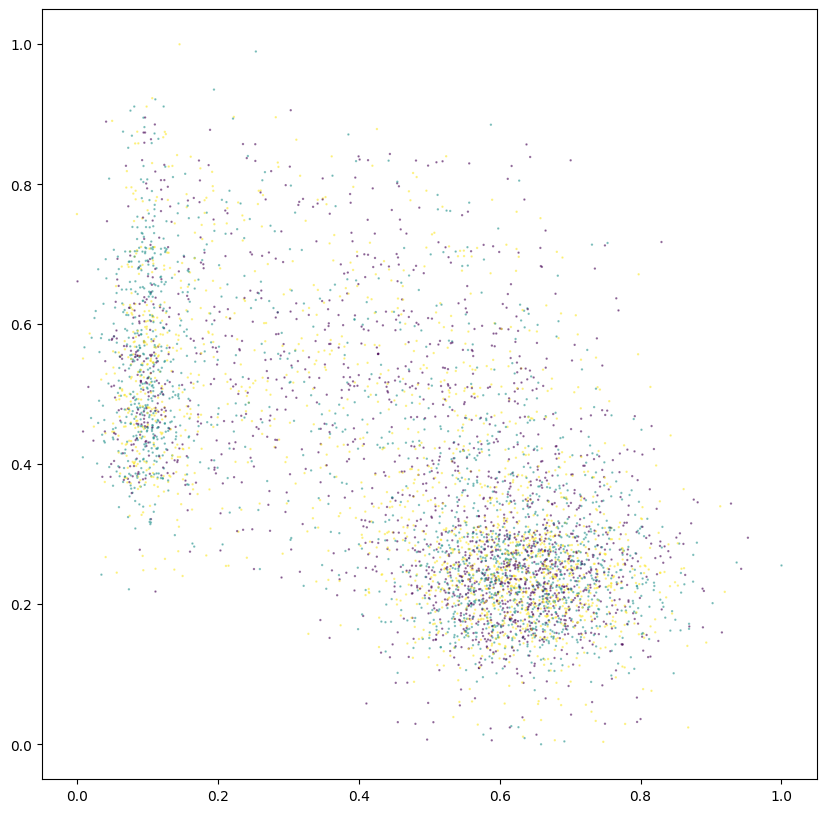

In [21]:
plt.figure(figsize=(10,10))
plt.scatter(data["GAP_close"], data["ZETA_std"], s = 1/2**1, c = y_bool, alpha=0.5)

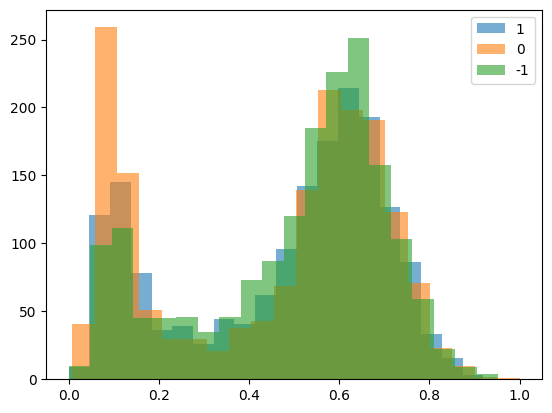

In [22]:
plt.hist(data[y_bool == 1]["GAP_close"], bins = 20, alpha = 0.6, label = "1")
plt.hist(data[y_bool == 0]["GAP_close"], bins = 20, alpha = 0.6, label = "0")
plt.hist(data[y_bool == -1]["GAP_close"], bins = 20, alpha = 0.6, label = "-1")
plt.legend()
plt.show()